### Import libraries

In [8]:
# Importing libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Customize

In [9]:
# Customization
input_path = "0803 Gym Dataset.csv"
cust_data = "0803 Churn_Customer_Data.csv"
churn_risk = "0803 Churn_Risk.csv"
conf_matrix_img = "0803 confusion_matrix.png"
feature_importance_img = "0803 feature_importance_plot.png"
pie_chart_img = "0803 churn_risk_pie_chart.png"
my_categories= ['gender', 'distance_from_gym', 'works_at_partner_company', 'discounted_signup', 'attends_group_classes', 'referred_by_friend']
my_features= ['age', 'gender', 'days_since_last_signed_in', 'distance_from_gym', 'works_at_partner_company', 'discounted_signup', 'avg_monthly_visits', 'attends_group_classes', 'referred_by_friend']
my_target='churned'

### Read and preprocess data

In [10]:
df = pd.read_csv(input_path)
categorical_cols = my_categories
features = my_features 

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[features]
y = df[my_target]


### Fit model, make predictions, assign churn risk scores

In [11]:
# Train-test model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions and assign churn scores
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] 

# Assign churn risk level
def assign_risk(prob):
    if prob < 0.33:
        return 1
    elif prob < 0.66:
        return 2
    else:
        return 3

churn_risk_scores = [assign_risk(p) for p in y_proba]

# Add interpretation column
def interpret_risk(score):
    mapping = {
        1: "No action needed",
        2: "Monitor regularly",
        3: "Needs immediate intervention"
    }
    return mapping[score]

risk_interpretation = [interpret_risk(r) for r in churn_risk_scores]

### Generate dataframe, display data, and save results

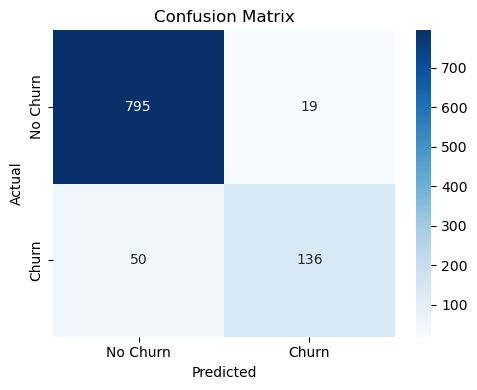

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       814
           1       0.88      0.73      0.80       186

    accuracy                           0.93      1000
   macro avg       0.91      0.85      0.88      1000
weighted avg       0.93      0.93      0.93      1000



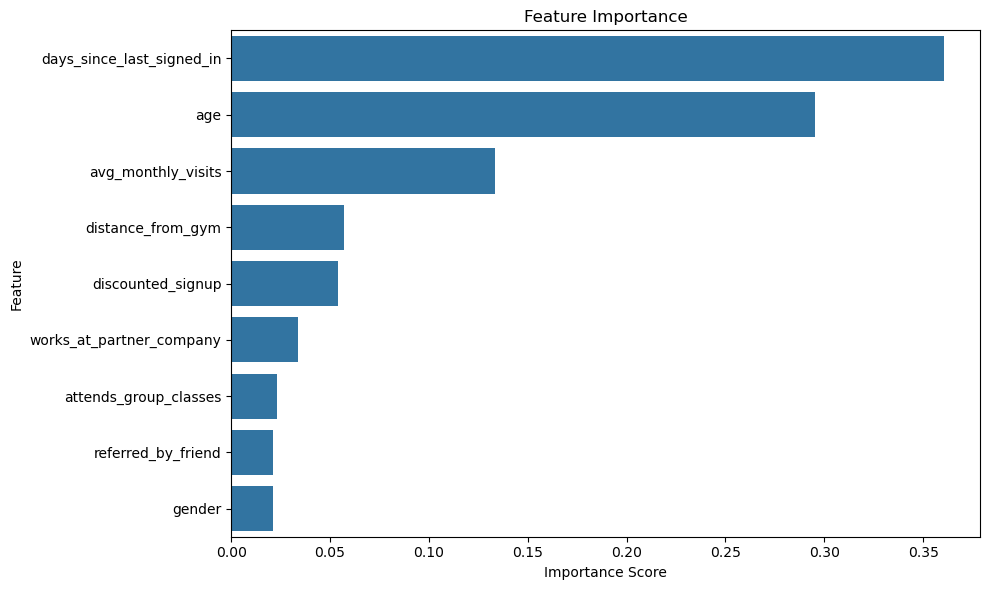

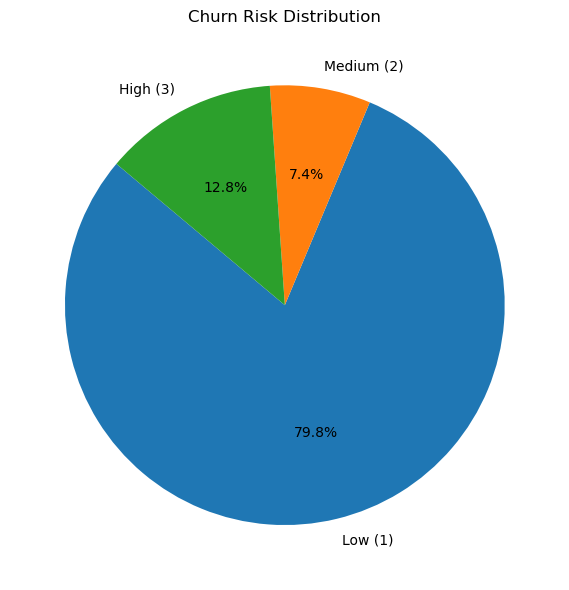


Churn Feature Averages:
         days_since_last_signed_in    age  avg_monthly_visits
churned                                                      
0                            12.73  33.07               13.04
1                            29.64  43.06               10.08

The csv reports with the churn risk scores have been saved.


In [12]:
# Displaying and saving the results

# For detailed customer data
full_df = df.copy()
full_df['predicted_churned'] = y
full_df['churn_probability'] = model.predict_proba(X)[:, 1].round(3)
full_df.to_csv(cust_data, index=False)

# For recommended action
id_col = df.columns[0]  # assumes first column is unique identifier
risk_df = pd.DataFrame({
    id_col: df.loc[X_test.index, id_col].values,
    'churn_risk': churn_risk_scores,
    'action_recommended': risk_interpretation
})
risk_df.to_csv(churn_risk, index=False)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(conf_matrix_img)
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plotting feature importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(feature_importance_img)
plt.show()

# Plotting pie-chart
risk_counts = pd.Series(churn_risk_scores).value_counts().sort_index()
risk_labels = ['Low (1)', 'Medium (2)', 'High (3)']
plt.figure(figsize=(6, 6))
plt.pie(risk_counts, labels=risk_labels, autopct='%1.1f%%', startangle=140)
plt.title('Churn Risk Distribution')
plt.tight_layout()
plt.savefig(pie_chart_img)
plt.show()

# Displaying churn feature averages
top_features = importances.head(3).index.tolist()
avg_values = df.groupby('churned')[top_features].mean().round(2)

print("\nChurn Feature Averages:")
print(avg_values)

print ("\nThe csv reports with the churn risk scores have been saved.")